In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

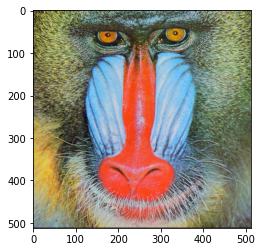

In [2]:
img = plt.imread("mandrill.jpg")
_ = plt.imshow(img)

In [3]:
step = 2
img_array = img
img_array_cutted = np.array(img[::step,::step].copy(), dtype=np.uint8)

--- 0.03844738006591797 seconds ---


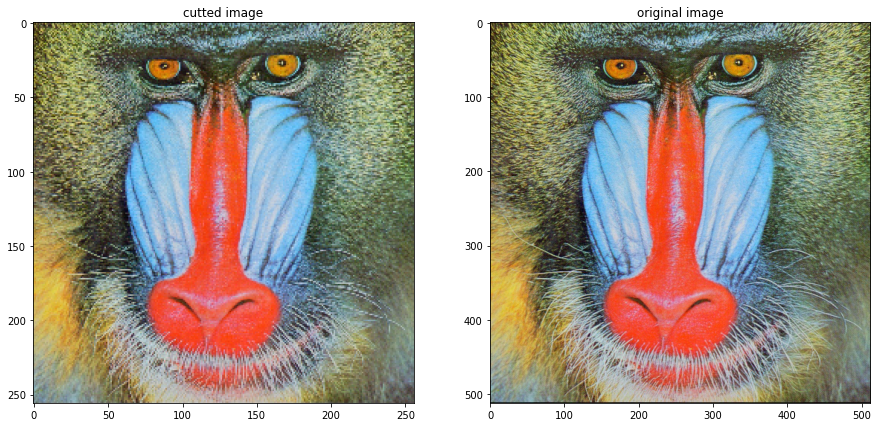

In [4]:
def show(new_img, img, name1: str, name2 = 'original image'):
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 15))
    ax1.set_title(name1)
    _ = ax1.imshow(new_img)
    ax2.set_title(name2)
    _ = ax2.imshow(img)
    
start_time = time.time()
show(img_array_cutted, img, 'cutted image')
print("--- %s seconds ---" % (time.time() - start_time))

In [5]:
img_array_cutted.reshape(-1,3)

array([[164, 145,  86],
       [ 70,  43,  13],
       [158, 138,  85],
       ...,
       [ 93,  83,  82],
       [ 88,  79,  82],
       [ 84,  74,  75]], dtype=uint8)

# Сплайн второго порядка 

Формула с 4 мультипликативными операциями

In [26]:
def u(x, x_j, x_j1, u_j, u_j1):
    if x_j < x < x_j1:
        array = np.abs( u_j * (x - x_j1) / (x_j - x_j1) + u_j1 * (x - x_j) / (x_j1 - x_j))
        return np.where(array > 255, 255, array)
    else:
        assert("Error!")

Формула с 2 мультипликативными операциями

In [35]:
def u_new(x, x_j, x_j1, u_j, u_j1):
    if x_j < x < x_j1:
        array = np.abs(u_j + (u_j1 - u_j) * (x - x_j) / (x_j1 - x_j))
        return np.where(array > 255, 255, array)
    else:
        assert("Error!")

Формула с заранее вычеслеными коэфициентами

In [36]:
def u_known(x, x_j, x_j1, u_j, u_j1):
    if x_j < x < x_j1:
        array = np.abs(0.5 * u_j + 0.5*u_j1)
        return np.where(array > 255, 255, array)
    else:
        assert("Error!")

--- 3.6601240634918213 seconds ---


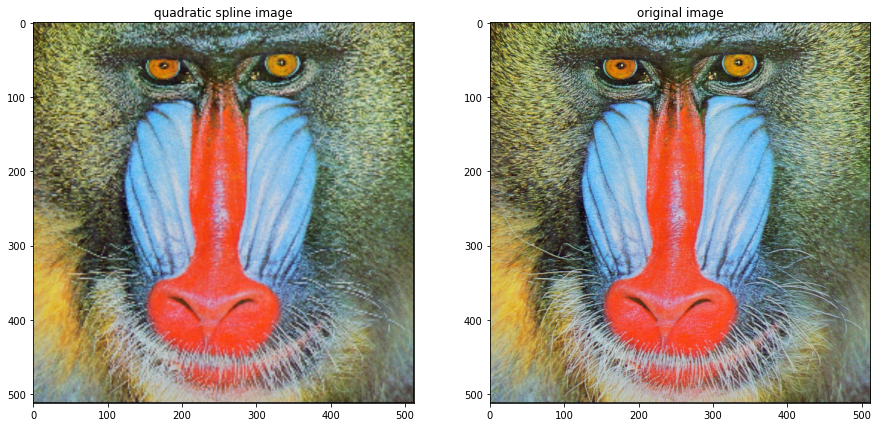

In [37]:
def quadratic_spline(img_array_cutted: np.array, step: int):
    n = img_array_cutted.shape[0]
    m = img_array_cutted.shape[1]
    new_img = np.zeros(img.shape, dtype=np.uint8)
    
#   копируем то что было
    for i in range(n):
        for j in range(m):
            new_img[2*i][2*j] = img_array_cutted[i][j]
            
#   восстанавливаем строки
    for i in range(0, 2*n):
        for j in range(1, 2*m - 1, 2):
            new_img[i][j] = u_known(j, j-1, j+1, new_img[i][j-1], new_img[i][j+1])

#   восстанавливаем столбцы
    for j in range(0, 2*m):
        for i in range(1, 2*n - 1, 2):
            new_img[i][j] = u_known(i, i-1, i+1, new_img[i-1][j], new_img[i+1][j])  

    return new_img


start_time = time.time()
new_img_quadratic = quadratic_spline(img_array_cutted, step)
print("--- %s seconds ---" % (time.time() - start_time))

show(new_img_quadratic, img, 'quadratic spline image')

# Сплайн третьего порядка

Формулы с 12 мультипликативными операциями

In [22]:
def first_w_j (x, x_j, x_j1, x_j2):
    return (x - x_j1)*(x - x_j2)/((x_j - x_j1)*(x_j - x_j2))
    
def first_w_j1(x, x_j, x_j1, x_j2):
    return (x - x_j)*(x - x_j2)/((x_j1 - x_j)*(x_j1 - x_j2))
    
def first_w_j2(x, x_j, x_j1, x_j2):
    return (x - x_j1)*(x - x_j)/((x_j2 - x_j1)*(x_j2 - x_j))
    

def right_u(x, x_j, x_j1, x_j2, u_j, u_j1, u_j2):
    
    array = np.abs(u_j*first_w_j(x,x_j,x_j1,x_j2) + u_j1*first_w_j1(x,x_j,x_j1,x_j2)  + u_j2*first_w_j2(x,x_j,x_j1,x_j2))
    
    return  np.where(array > 255, 255, array)

In [23]:
def second_w_j (x, x_j, x_j1, x_j_1):
    return (x - x_j1)*(x - x_j_1)/((x_j - x_j1)*(x_j - x_j_1))
    
def second_w_j1(x, x_j, x_j1, x_j_1):
    return (x - x_j)*(x - x_j_1)/((x_j1 - x_j_1)*(x_j1 - x_j))
    
def second_w_j_1(x, x_j, x_j1, x_j_1):
    return (x - x_j1)*(x - x_j)/((x_j_1 - x_j1)*(x_j_1 - x_j))
    

def left_u(x, x_j, x_j1, x_j_1, u_j, u_j1, u_j_1):
    
    array = np.abs(u_j*second_w_j(x,x_j,x_j1,x_j_1) + u_j1*second_w_j1(x,x_j,x_j1,x_j_1)  + u_j_1*second_w_j_1(x,x_j,x_j1,x_j_1))
        
    return np.where(array > 255, 255, array)

Обновленные формулы с 9 мультипликативными операциями

In [24]:
def right_u_new(x, x_j, x_j1, x_j2, u_j, u_j1, u_j2):
    A = (x - x_j1)/(x_j - x_j2)
    B = (x - x_j)/(x_j1 - x_j2)
    C = (x - x_j2)/(x_j - x_j1)
    
    array = np.abs(u_j*A*C - u_j1*B*C  + u_j2*A*B)
    
    return np.where(array > 255, 255, array)

In [25]:
def left_u_new(x, x_j, x_j1, x_j_1, u_j, u_j1, u_j_1):
    D = (x - x_j1)/(x_j - x_j_1)
    E = (x - x_j)/(x_j1 - x_j_1)
    F = (x - x_j_1)/(x_j - x_j1)
    
    array = np.abs(u_j*D*F - u_j1*F*E  + u_j_1*D*E)
    
    return np.where(array > 255, 255, array)

Формулы с заранее вычеслеными коэфициентами

In [39]:
def right_u_known(x, x_j, x_j1, x_j2, u_j, u_j1, u_j2):

    array = np.abs(u_j*0.375 + u_j1*0.75  - u_j2*0.125)
    
    return np.where(array > 255, 255, array)

In [40]:
def left_u_known(x, x_j, x_j1, x_j_1, u_j, u_j1, u_j_1):

    array = np.abs(u_j*0.375 + u_j1*0.75  - u_j_1*0.125)
    
    return np.where(array > 255, 255, array)

--- 4.321720123291016 seconds ---


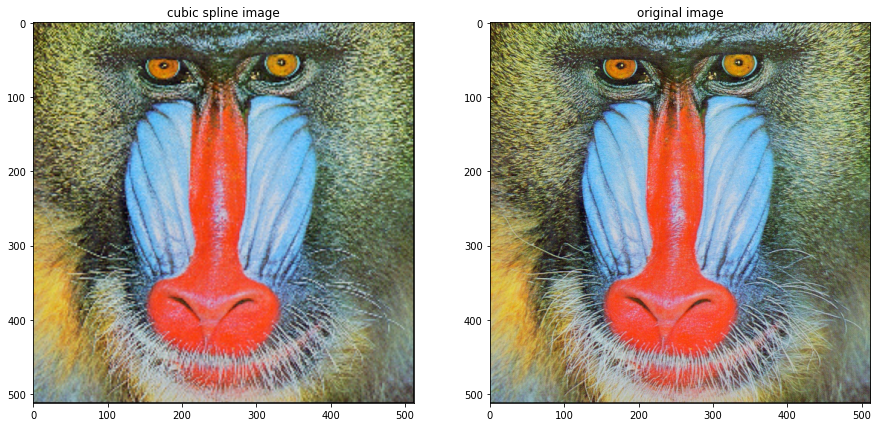

In [41]:
def cubic_spline(img_array_cutted: np.array, step: int):
    n = img_array_cutted.shape[0]
    m = img_array_cutted.shape[1]
    new_img = np.zeros(img.shape, dtype=np.uint8)
    
#   копируем то что было
    for i in range(n):
        for j in range(m):
            new_img[2*i][2*j] = img_array_cutted[i][j]
            
#   восстанавливаем строки
    for i in range(0, 2*n):
        for j in range(1, 2*m - 1, 2):
            
            if j < m:
                new_img[i][j] = right_u_known(j, j-1, j+1, j+3, new_img[i][j-1], new_img[i][j+1], new_img[i][j+3])
                
            else:
                new_img[i][j] = left_u_known(j, j-1, j+1, j-3, new_img[i][j-1], new_img[i][j+1], new_img[i][j-3])
            

#   восстанавливаем столбцы
    for j in range(0, 2*m):
        for i in range(1, 2*n - 1, 2):
            if i < n:
                new_img[i][j] = right_u_known(i, i-1, i+1, i+3, new_img[i-1][j], new_img[i+1][j], new_img[i+3][j])
                              
            else:
                new_img[i][j] = left_u_known(i, i-1, i+1, i-3, new_img[i-1][j], new_img[i+1][j], new_img[i-3][j])

    return new_img

start_time = time.time()
new_img_cubic = cubic_spline(img_array_cutted, step)
print("--- %s seconds ---" % (time.time() - start_time))

show(new_img_cubic, img, 'cubic spline image')        

# Не полиномиальный сплайн

--- 6.514920711517334 seconds ---


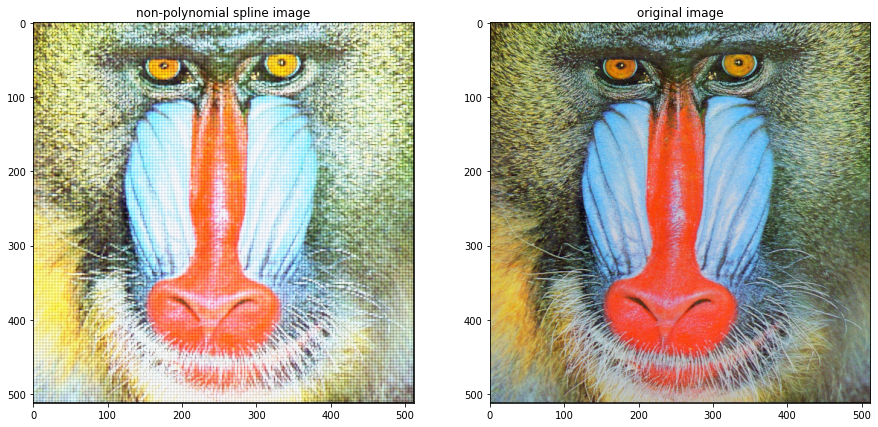

In [56]:
def w_j(x_j, t, h):
    return np.sin(h - t*h)/np.sin(h)
def w_j1(x_j, t, h):
    return np.cos(t*h)/np.sin(h)

def u_non_poly(t, x_j, x_j1, u_j, u_j1):
    
    h = 2
    t = 0.5
    
    array = np.abs(u_j*w_j(x_j, t, h) + u_j1*w_j1(x_j, t, h)) 
        
    return np.where(array > 255, 255, array)

def non_poly_spline(img_array_cutted: np.array, step: int):
    n = img_array_cutted.shape[0]
    m = img_array_cutted.shape[1]
    new_img = np.zeros(img.shape, dtype=np.uint8)
    
#   копируем то что было
    for i in range(n):
        for j in range(m):
            new_img[2*i][2*j] = img_array_cutted[i][j]
            
#   восстанавливаем строки
    for i in range(0, 2*n):
        for j in range(1, 2*m - 1, 2):
            new_img[i][j] = u_non_poly(j, j-1, j+1, new_img[i][j-1], new_img[i][j+1])

#   восстанавливаем столбцы
    for j in range(0, 2*m):
        for i in range(1, 2*n - 1, 2):
            new_img[i][j] = u_non_poly(i, i-1, i+1, new_img[i-1][j], new_img[i+1][j])
    
    return new_img

start_time = time.time()
new_img_non_poly = non_poly_spline(img_array_cutted, step)
print("--- %s seconds ---" % (time.time() - start_time))

show(new_img_non_poly, img, 'non-polynomial spline image') 

# Вычисление ошибки

In [57]:
# Метрика Евклида
def euclidean_dist(arr1 , arr2):
    return np.linalg.norm(arr1 - arr2)

    
# Ошибка с метрикой Евклида   
def error_euclidean(new_img: np.array, img:np.array):
    
    n = img.shape[0]
    m = img.shape[1]
    error = np.zeros(img.shape, dtype=np.uint8)
    
    for i in range(n):
        for j in range(m):
            eu = euclidean_dist(new_img[i][j], img[i][j])
            if eu >= 256:
                error[i][j] = 256
            else:
                error[i][j] = eu
    
    return error          

img1 = error_euclidean(new_img_quadratic, img)
img2 = error_euclidean(new_img_cubic, img)
img3 = error_euclidean(new_img_non_poly, img)

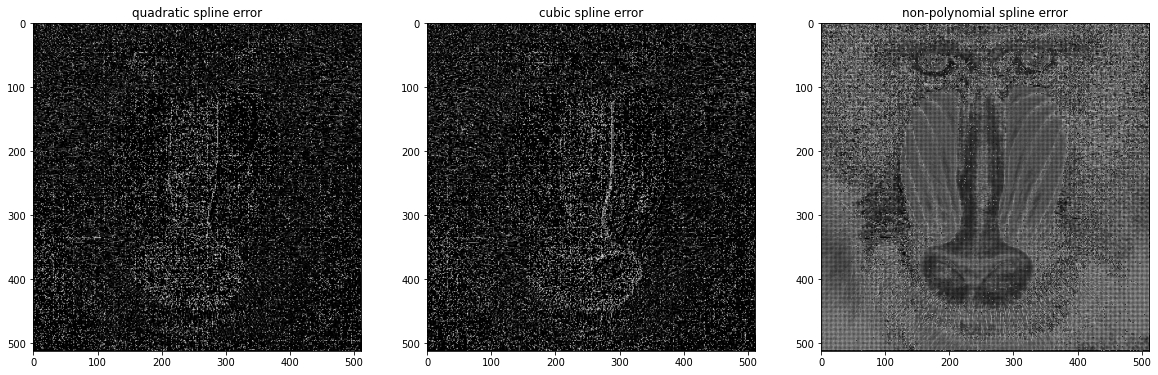

In [58]:
# Риусем ошибку    
def show_error(img1, img2, img3, name1: str, name2: str, name3: str):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 20))
    ax1.set_title(name1 + ' error')
    _ = ax1.imshow(img1)
    ax2.set_title(name2 + ' error')
    _ = ax2.imshow(img2) 
    ax3.set_title(name3 + ' error')
    _ = ax3.imshow(img3) 
    
show_error(img1, img2, img3, 'quadratic spline', 'cubic spline', 'non-polynomial spline')